# Mini challenge - NPM3D

## Imports

In [1]:
from datetime import datetime

import numpy as np
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import jaccard_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

from src import FeaturesExtractor, timeit, checkpoint, write_ply

In [2]:
# paths of the training and test files
training_path = "./data/training"
test_path = "./data/test"
# choosing MiniLille1 as our validation set because it is the smallest
validation_point_cloud = "MiniLille1.ply"

In [3]:
features_extractor = FeaturesExtractor()

## Model selection

In [4]:
def choose_model(model_name: str):
    if model_name == "sklearn":
        return RandomForestClassifier()
    elif model_name == "lgbm":
        return LGBMClassifier()
    elif model_name == "xgboost":
        return XGBClassifier()
    else:
        raise ValueError("Incorrect model name passed")

In [5]:
model_name = "lgbm"  # @param
clf = choose_model(model_name)

## Pipelines

In [6]:
@timeit
def save_prediction(
    clf,
    test_path: str,
    file_path: str = f"submissions/{model_name}-{datetime.now().strftime('%Y_%m_%d-%H_%M')}.txt",
):
    timer = checkpoint()
    test_features = features_extractor.extract_features_no_label(test_path)
    timer("Time spent computing test features")

    predictions = clf.predict(test_features)
    timer("Time spent on test prediction")

    assert predictions.shape[0] == 3079187, "Incorrect number of predictions"

    if model_name == "xgboost":
        predictions += 1

    np.savetxt(
        file_path,
        predictions,
        fmt="%d",
    )
    timer(f"Time spent writing results on {file_path}")

In [7]:
@timeit
def test(
    clf,
    test_features: np.ndarray,
    test_labels: np.ndarray,
    point_cloud: np.ndarray,
    file_path: str = f"submissions/point_clouds/{model_name}-{datetime.now().strftime('%Y_%m_%d-%H_%M')}.ply",
) -> None:
    prediction = clf.predict(test_features)
    print(f"Accuracy:      {accuracy_score(test_labels, prediction) * 100:.2f}%")
    print(
        f"Jaccard score: {jaccard_score(test_labels, prediction, average='micro'):.4f}"
    )
    ConfusionMatrixDisplay.from_predictions(test_labels, prediction)
    write_ply(
        file_path,
        [
            point_cloud,
            prediction,
            test_labels,
        ],
        ["x", "y", "z", "predicted_label", "true_label"],
    )

## Experiments

## Testing the model with one point cloud for validation

In [8]:
%%time
test_point_cloud = features_extractor.extract_point_clouds(
    training_path, validation_point_cloud
)[2]


Reading file MiniParis1.ply
1210261 elements available for class Ground
1071599 elements available for class Building
24787 elements available for class Poles
32396 elements available for class Pedestrians
50468 elements available for class Cars
1455156 elements available for class Vegetation

Reading file MiniLille1.ply
767722 elements available for class Ground
864939 elements available for class Building
5532 elements available for class Poles
0 elements available for class Pedestrians
114237 elements available for class Cars
104182 elements available for class Vegetation

Reading file MiniLille2.ply
1074040 elements available for class Ground
1000935 elements available for class Building
13094 elements available for class Poles
0 elements available for class Pedestrians
96132 elements available for class Cars
261365 elements available for class Vegetation
CPU times: user 251 ms, sys: 90.6 ms, total: 341 ms
Wall time: 397 ms


In [9]:
%%time
train_features, train_labels = features_extractor.extract_features(training_path)
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)


Reading file MiniParis1.ply
Using cached features and labels

Reading file MiniLille1.ply
Using cached features and labels

Reading file MiniLille2.ply
Using cached features and labels
CPU times: user 75.5 ms, sys: 639 ms, total: 714 ms
Wall time: 1.17 s


In [10]:
if model_name == "xgboost":
    train_labels -= 1
    train_labels = train_labels.astype(int)

In [11]:
%%time
clf.fit(X_train, y_train)

CPU times: user 4min 40s, sys: 12 s, total: 4min 52s
Wall time: 57.3 s


LGBMClassifier()

In [12]:
print(f"Training set score: {clf.score(X_train, y_train):.4f}")
print(f"Test set score: {clf.score(X_val, y_val):.4f}")

Training set score: 0.9999
Test set score: 0.8793


Accuracy:      87.93%
Jaccard score: 0.7845
Function test took 2.69 seconds


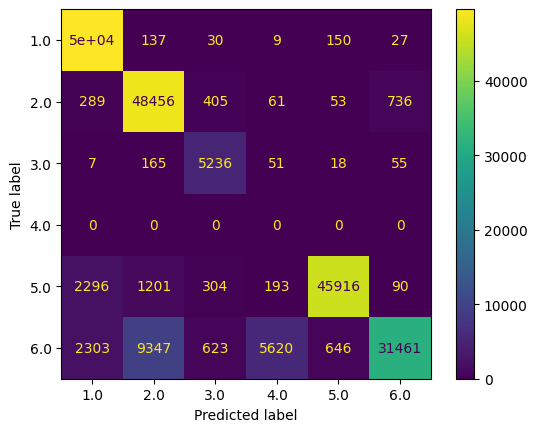

In [13]:
test(clf, X_val, y_val, test_point_cloud)

## Training the model on all three point clouds

## Cross validation

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold

gkf = KFold(shuffle=True, random_state=42).split(X=train_features, y=train_labels)

param_grid = {
    "learning_rate": [1e-2, 1e-3],
    "num_leaves": [27, 31, 127],
    # "reg_alpha": [0.1, 0.5],
    # "reg_lambda": [0.1, 0.5],
    # "min_child_samples": [18, 20],
    # "min_child_weight": [5e-4, 1e-3],
}

gsearch = GridSearchCV(estimator=clf, param_grid=param_grid, cv=gkf)
lgb_model = gsearch.fit(X=train_features, y=train_labels)

print(lgb_model.best_params_, lgb_model.best_score_)

gsearch = GridSearchCV(estimator=clf, param_grid=param_grid, cv=gkf)
lgb_model = gsearch.fit(X=train_features, y=train_labels)

print(lgb_model.best_params_, lgb_model.best_score_)

In [ ]:
%%time
clf.fit(train_features, train_labels)

In [ ]:
save_prediction(clf, test_path)

Remove ground and perform region growing + majority vote (class importance in vote can be learning).